# A guide to paticle motion estimation with `pyusel-dispest`

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

# Define the test data

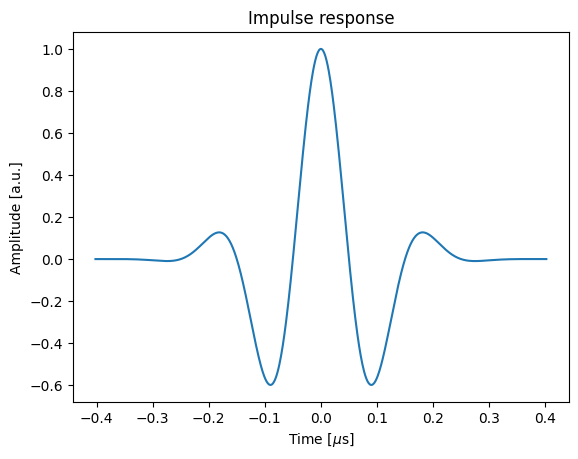

In [2]:
# define the imaging PSF
bw=80/100
f = 5E6
c = 1540
fs = 1E9

tc = sig.gausspulse('cutoff', bw=bw, tpr=-80, fc=f)
Ntc = np.ceil(tc*fs)
timp = (np.arange(2*Ntc+1)-Ntc)/fs
imp = sig.gausspulse(t=timp, bw=bw, tpr=-80, fc=f)

plt.figure()
plt.plot(1E6*timp, imp)
plt.xlabel("Time [$\\mu$s]")
plt.ylabel("Amplitude [a.u.]")
plt.title("Impulse response")
plt.show()

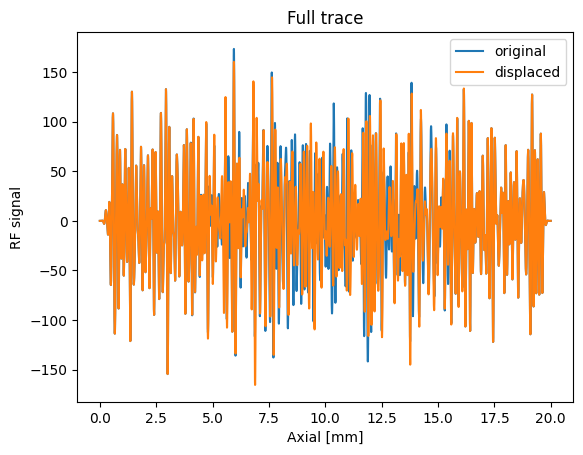

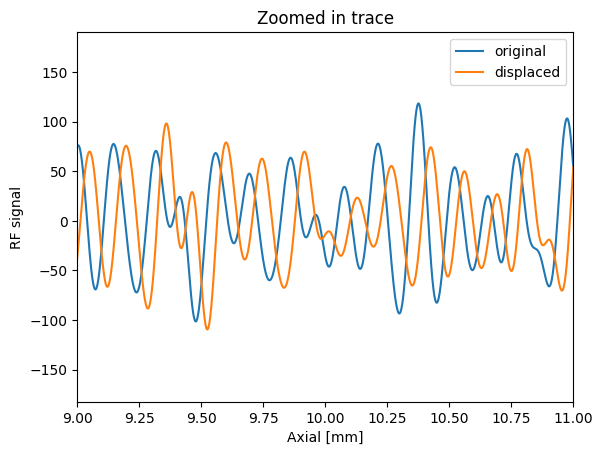

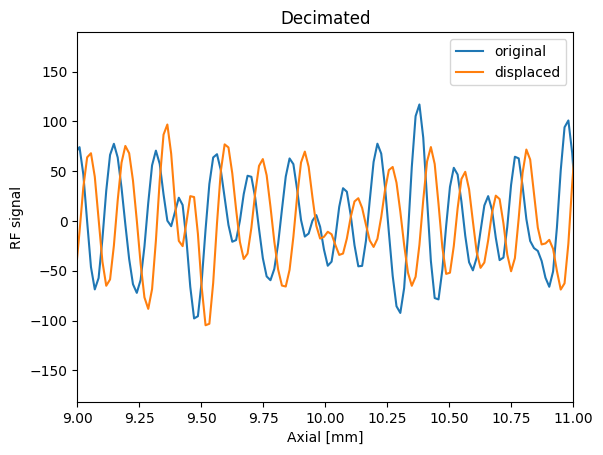

In [3]:
# define the scatterer field
dx = c/(2*fs)
x = np.arange(0, 20E-3, dx)
rng = np.random.default_rng()

x0 = rng.uniform(dx*Ntc, dx*(len(x)-Ntc), 10000)
ix0 = np.round(x0/dx).astype(int)
a0 = rng.normal(0, 10, 10000)
scat = np.zeros(len(x))
scat[ix0] += a0

# Undisplaced signal
trace0 = np.convolve(imp, scat, mode='same')


# define the displacement field
f_disp = lambda x, mag=50E-6: mag*np.exp(-(x-10E-3)**2/(2E-3**2))

ix0 = np.round((x0+f_disp(x0))/dx).astype(int)
scat = np.zeros(len(x))
scat[ix0] += a0

# displaced signal
trace1 = np.convolve(imp, scat, mode='same')

plt.figure()
plt.plot(1E3*x, trace0, label='original')
plt.plot(1E3*x, trace1, label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Full trace")
plt.show()

plt.figure()
plt.plot(1E3*x, trace0, label='original')
plt.plot(1E3*x, trace1, label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Zoomed in trace")
plt.xlim(9, 11)
plt.show()

plt.figure()
plt.plot(1E3*x[::20], trace0[::20], label='original')
plt.plot(1E3*x[::20], trace1[::20], label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Decimated")
plt.xlim(9, 11)
plt.show()

s0 = trace0[::10]
s1 = trace1[::10]

## Displacement estimation using Kasai algorithm

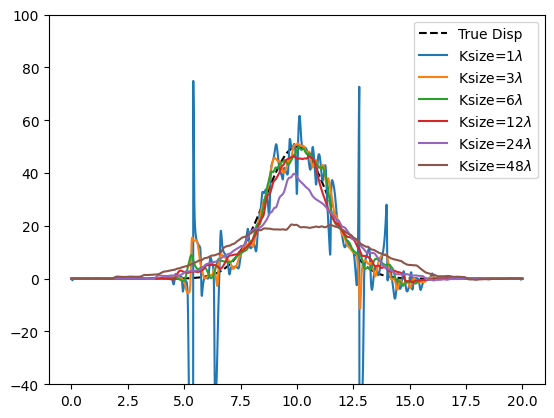

In [4]:
import dispest as de

# convert rfsignal to IQ to get phase information
IQ0 = sig.hilbert(s0).reshape((-1,1))
IQ1 = sig.hilbert(s1).reshape((-1,1))
IQ = np.concatenate((IQ0, IQ1), axis=1)
I = np.real(IQ)
Q = np.imag(IQ)

plt.figure()
plt.plot(1E3*x[::10], 1E6*f_disp(x[::10]), color='k', linestyle='--', label='True Disp')

# calculate displacement with different kernel lengths
disps = []
for lam in [1, 3, 6, 12, 24, 48]:
    ksize = int(np.round(lam*fs/(10*f)))
    disp = de.calc_kasai(I, Q, taxis=1, fd=f, c=c, ksize=ksize, kaxis=0)
    plt.plot(1E3*x[::10], disp, linestyle='-', label=  f"Ksize={lam}" + '$\\lambda $')

plt.legend()
plt.ylim(-40, 100)
plt.show()


# Normalized Cross correlation

In [5]:
def get_xcorr_inds(Ns:int, lenref:int, refstep:int, searchpm:int):
    kern = np.arange(lenref, dtype=int)
    iref_start = np.arange(0, Ns-lenref, refstep, dtype=int)
    iserpm = np.arange(-searchpm, searchpm+1, dtype=int)

    selref = iref_start[:,None, None] + kern[None,None,:]
    selser = selref + iserpm[None,:,None]

    outbnd = (selser < 0) | (selser >= Ns)

    selser[outbnd] = 0

    seliref = np.arange(selref.shape[0], dtype=int)[None,:] * np.ones((3,1), dtype=int)

    return selref, selser, outbnd, seliref

In [112]:
def nxcorr_by_inds_mu(sigref, sigsearch, selref, selser, outbnd, seliref):
    REF = sigref[selref]
    SER = sigsearch[selser]
    SER[outbnd] = np.nan
    searchpm = int((SER.shape[1]-1)//2)

    REF -= np.mean(REF, axis=2).reshape(REF.shape[0], REF.shape[1], 1)
    REF_STD = np.std(REF, axis=2)
    SER -= np.mean(SER, axis=2).reshape(SER.shape[0], SER.shape[1], 1)
    SER_STD = np.std(SER, axis=2)

    CROSS = np.mean(REF * SER, axis=2)
    RHOS = CROSS/(SER_STD*REF_STD)

    imax = np.nanargmax(RHOS, axis=1)
    invbnd = (imax < 1) | (imax >= 2*searchpm)
    imax[invbnd] = searchpm
    sellag = imax[None,:] + np.array([[-1, 0, 1]], dtype=int).T

    peaks = RHOS[seliref, sellag]
    a = (peaks[0] + peaks[2])/2 - peaks[1]
    b = (peaks[2] - peaks[0])/2
    c = peaks[1]

    dmax = -b/(2*a)
    dmax[invbnd] = np.nan
    rhomax = a*dmax*dmax + b*dmax + c

    return imax-searchpm+dmax, rhomax

In [7]:
selref, selser, outbnd, seliref = get_xcorr_inds(len(s0), 300, 5, 50)

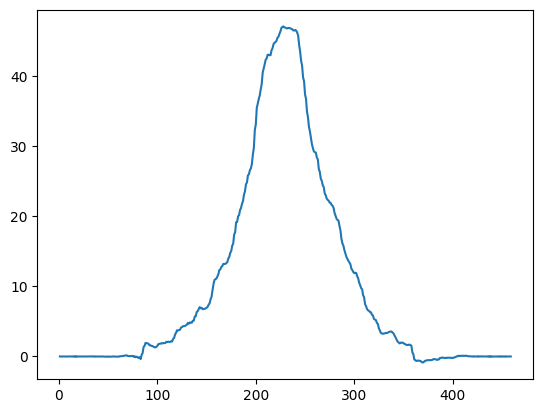

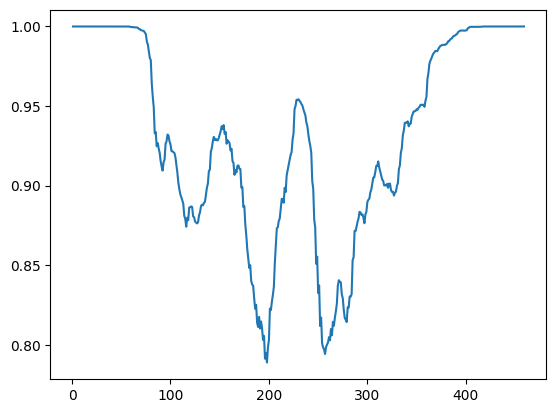

In [8]:
idx, rhos = nxcorr_by_inds_mu(s0, s1, selref, selser, outbnd, seliref)

plt.figure()
plt.plot(10E6*c*idx/(2*fs))
plt.show()

plt.figure()
plt.plot(rhos) 
plt.show()

In [10]:
from hdf5storage import loadmat
params = loadmat("/home/wren/Documents/data/phantom/acq00_tilt00.0deg_dur400cyc_fnum2/ChannelPost/bulkDAS/tracking.mat", simplify_cells=True)

In [83]:
irep = params['dims']['rep']
istr = params['dims']['steer']
axial = params['dims']['axial']
lateral = params['dims']['lat']

data = np.fromfile("/home/wren/Documents/data/phantom/acq00_tilt00.0deg_dur400cyc_fnum2/ChannelPost/bulkDAS/tracking.bin",dtype=np.float32).reshape(len(irep), len(istr), len(axial), len(lateral))
lateral = lateral

In [84]:
from scipy.signal import hilbert

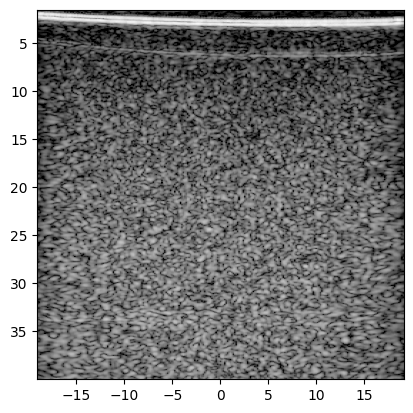

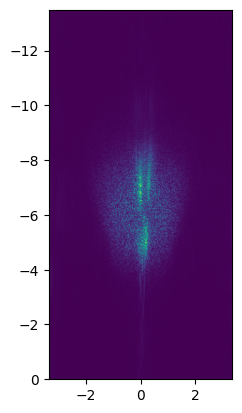

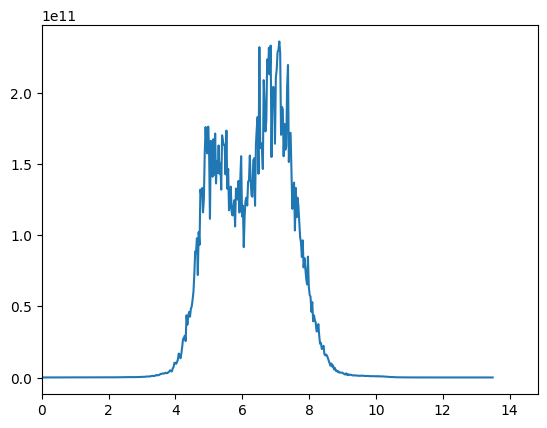

In [85]:
data.shape
rf = np.mean(data[0,:,:,:], axis=0)
env = np.abs(hilbert(rf, axis=0))
logged = 20*np.log10(env/np.percentile(env, 99))

plt.figure()
plt.imshow(logged, extent=1E3*np.array([lateral[0], lateral[-1], axial[-1], axial[0]]), cmap='gray', vmin=-35, vmax=5)
plt.show()

freq = np.fft.fftshift(np.abs(np.fft.fft2(rf)))
kax = np.fft.fftshift(np.fft.fftfreq(rf.shape[0], 1E3*(axial[1]-axial[0])))
klat = np.fft.fftshift(np.fft.fftfreq(rf.shape[1], 1E3*(lateral[1]-lateral[0])))

plt.figure()
plt.imshow(freq, extent=[klat[0], klat[-1], kax[-1], kax[0]])
plt.ylim(0, None)
plt.show()

freq_onaxis = np.fft.fftshift(np.mean(np.abs(np.fft.fft(rf, axis=0)), axis=1))

plt.figure()
plt.plot(kax, freq_onaxis**2)
plt.xlim(0,None)
plt.show()

In [216]:
def roll(rf, taxis:int=0, raxis:int=1):
    """Compute rolling average of a data tensor"""
    nt = rf.shape[taxis]
    na = rf.shape[raxis]
    
    # make ouput buffer and expected shapes
    rolled_shape = [*rf.shape]
    rolled_shape[taxis] = int(na*(nt-1)+1)
    rolled_shape.pop(raxis)
    rolled = np.zeros(rolled_shape)

    if raxis < taxis: taxis_rolled = taxis-1
    else: taxis_rolled = taxis
    
    for ii in range(na):
        slice_rolled = [slice(None)] * np.ndim(rolled)
        slice_rolled[taxis_rolled] = slice(ii,None,na)
        for jj in range(na):
            # if (ii == (na-1)) and (jj == (na-1)):
            #     slice_rolled[taxis_rolled] = slice(ii,-1,na)
            slice_sub = [slice(None)] * np.ndim(rf)
            slice_sub[raxis] = jj
            istart = 0
            if jj < ii: istart = 1
            iend = nt
            if (ii > 0) and (jj>=ii): iend=nt-1
            slice_sub[taxis] = slice(istart,iend,None)
            rolled[*slice_rolled] += rf[*slice_sub]

    return rolled

rolled = roll(data)

In [249]:
from scipy.signal import resample
rolled, axial = resample(rolled, rolled.shape[1]*4, axial, axis=1, window='tukey')

In [263]:
selref, selser, outbnd, seliref = get_xcorr_inds(rolled.shape[1], 16*12, 20, 3)

vel = np.zeros((rolled.shape[0]-1, selref.shape[0], rolled.shape[2]))
rhos = np.zeros((rolled.shape[0]-1, selref.shape[0], rolled.shape[2]))

for it in range(vel.shape[0]):
    ref = rolled[it,:,:]
    track = rolled[it+1,:,:]
    for ilat, (r, s) in enumerate(zip(ref.T, track.T)):
        idx, rho = nxcorr_by_inds_mu(r, s, selref, selser, outbnd, seliref)
        vel[it,:,ilat] = idx
        rhos[it,:,ilat] = rho
        
vel = 1E6 * (axial[1]-axial[0]) * vel / 0.1

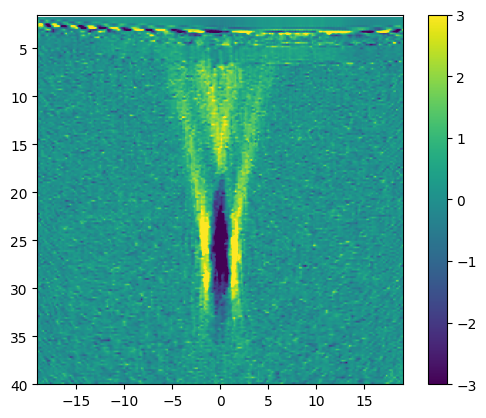

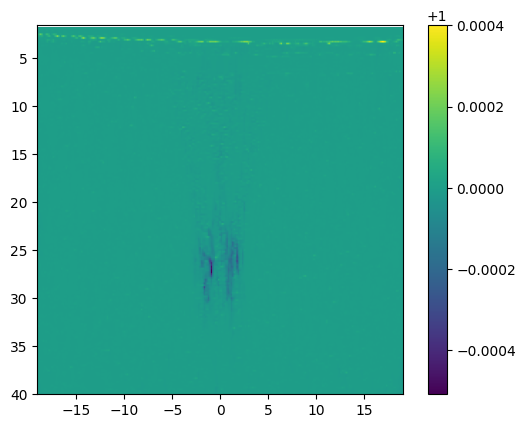

In [264]:
it = 20
plt.figure()
plt.imshow(vel[it,:,:], extent=1E3*np.array([lateral[0], lateral[-1], axial[-1], axial[0]]), vmin=-3, vmax=3)
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(rhos[it,:,:], extent=1E3*np.array([lateral[0], lateral[-1], axial[-1], axial[0]]))
plt.colorbar()
plt.show()

In [252]:
data.shape

(124, 3, 1041, 257)

In [253]:
rolled.shape

(370, 4164, 257)

In [256]:
vel.shape

(369, 204, 257)

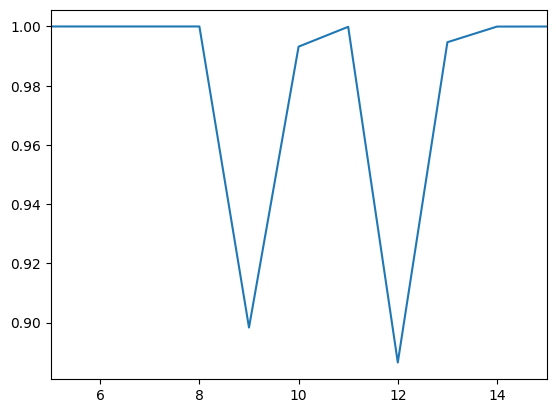

In [254]:
cross = np.sum(rolled[:-1,:,:] * rolled[1:,:,:], axis=(1,2))
self0 = np.sum(rolled[:-1,:,:] * rolled[:-1,:,:], axis=(1,2))
self1 = np.sum(rolled[1:,:,:] * rolled[1:,:,:], axis=(1,2))

rhos = cross/np.sqrt(self0*self1)

plt.figure()
plt.plot(rhos)
plt.xlim(5,15)
plt.show()

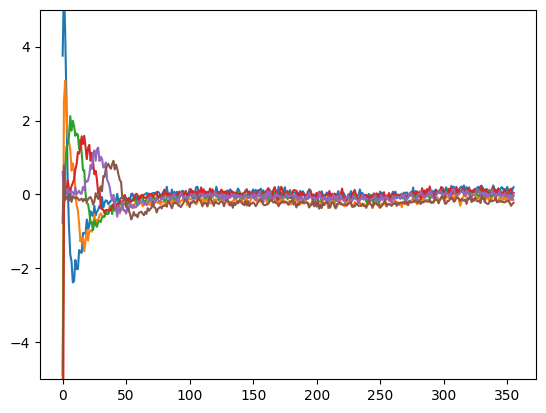

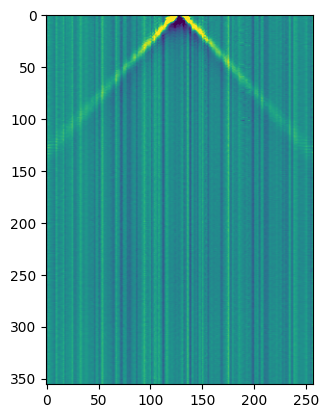

In [278]:
plt.figure()
plt.plot(vel[13:,100,128:172:8])

plt.ylim(-5,5)
plt.show()

plt.figure()
plt.imshow(vel[13:,120,:], vmin=-3, vmax=3)
plt.show()